# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Import the necessary libraries

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd
import numpy as np

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Great Learning/Residency 9/Internal Lab/')

### Load the training data from train.csv file

In [50]:
dataset_folder = "/content/drive/My Drive/Great Learning/Residency 9/Internal Lab/"
train_csv = dataset_folder + "train_labels.csv"
train_updated_csv = dataset_folder + "train_labels_updated.csv"

train = pd.read_csv(train_csv)
print(train.head())
train_df = pd.read_csv(train_updated_csv)
train_df.head()

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


,raccoon-17.jpg,259,194,95,60,167,118
0,raccoon-11.jpg,660,432,3,1,461,431
1,raccoon-63.jpg,600,400,74,107,280,290
2,raccoon-63.jpg,600,400,227,93,403,298
3,raccoon-60.jpg,273,185,58,33,197,127
4,raccoon-69.jpg,205,246,12,11,188,240


### Print the shape of the train dataset

In [51]:
path = os.listdir('/content/drive/My Drive/Great Learning/Residency 9/Internal Lab/images/')
print(path)
print(train_df.shape)

['raccoon-1.jpg', 'raccoon-101.jpg', 'raccoon-100.jpg', 'raccoon-10.jpg', 'raccoon-106.jpg', 'raccoon-107.jpg', 'raccoon-103.jpg', 'raccoon-102.jpg', 'raccoon-104.jpg', 'raccoon-105.jpg', 'raccoon-109.jpg', 'raccoon-11.jpg', 'raccoon-114.jpg', 'raccoon-108.jpg', 'raccoon-110.jpg', 'raccoon-113.jpg', 'raccoon-115.jpg', 'raccoon-111.jpg', 'raccoon-116.jpg', 'raccoon-112.jpg', 'raccoon-118.jpg', 'raccoon-119.jpg', 'raccoon-122.jpg', 'raccoon-12.jpg', 'raccoon-124.jpg', 'raccoon-121.jpg', 'raccoon-120.jpg', 'raccoon-125.jpg', 'raccoon-123.jpg', 'raccoon-117.jpg', 'raccoon-126.jpg', 'raccoon-127.jpg', 'raccoon-128.jpg', 'raccoon-134.jpg', 'raccoon-129.jpg', 'raccoon-131.jpg', 'raccoon-132.jpg', 'raccoon-13.jpg', 'raccoon-133.jpg', 'raccoon-130.jpg', 'raccoon-136.jpg', 'raccoon-138.jpg', 'raccoon-137.jpg', 'raccoon-139.jpg', 'raccoon-140.jpg', 'raccoon-14.jpg', 'raccoon-142.jpg', 'raccoon-135.jpg', 'raccoon-141.jpg', 'raccoon-143.jpg', 'raccoon-146.jpg', 'raccoon-144.jpg', 'raccoon-148.jpg',

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open(train_updated_csv, 'r') as csvfile:
    files = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
               
        for i, r in enumerate(row[1:6]): # Parse row with seven entities
            row[i+1] = int(r)
              
        filename, image_width, image_height,x0, y0, x1, y1 = row  
        filename = "/content/drive/My Drive/Great Learning/Residency 9/Internal Lab/images/" + filename
        coords[col,0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col,1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col,2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col,3] = (int(y1) - int(y0)) * IMAGE_SIZE / image_height
        files.append(filename)



### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(files), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(files):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [77]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [79]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
173/173 [==============================] - 1s 7ms/step - loss: 3132.8790 - IoU: 0.0669
Epoch 2/30
173/173 [==============================] - 0s 711us/step - loss: 789.0501 - IoU: 0.3888
Epoch 3/30
173/173 [==============================] - 0s 618us/step - loss: 604.0337 - IoU: 0.5391
Epoch 4/30
173/173 [==============================] - 0s 563us/step - loss: 624.4037 - IoU: 0.5185
Epoch 5/30
173/173 [==============================] - 0s 515us/step - loss: 400.5665 - IoU: 0.5748
Epoch 6/30
173/173 [==============================] - 0s 499us/step - loss: 274.7174 - IoU: 0.5746
Epoch 7/30
173/173 [==============================] - 0s 494us/step - loss: 241.9468 - IoU: 0.6112
Epoch 8/30
173/173 [==============================] - 0s 519us/step - loss: 204.4747 - IoU: 0.6549
Epoch 9/30
173/173 [==============================] - 0s 507us/step - loss: 165.1259 - IoU: 0.6957
Epoch 10/30
173/173 [==============================] - 0s 491us/step - loss: 150.4541 - IoU: 0.7139
Epoch 11/3

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
image_name = '/content/drive/My Drive/Great Learning/Residency 9/Internal Lab/images/raccoon-144.jpg'
unscaled = cv2.imread(image_name) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

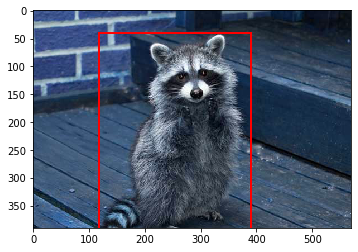

In [87]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()